# Crime Severity Data

## This notebook processes Crime Severity Index (CSI) and Incedent based violation detail data from StatCan  
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510002601
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510017701

# Install required packages
## Need these packages for writing out parquet data using pandas

In [1]:
%pip install pyarrow fastparquet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from functions import parameters as p
from functions import crime_severity as rd
from functions import statcan_data as sd
from functions import utilities as u



project_parameters = p.Project_Parameters()

In [3]:
params_download_crime_severity_data = {
    'project_parameters': project_parameters,
    'data_key': 'crime_severity',
}

status_csi = sd.download_statcan_data(params_download_crime_severity_data)
zipfilename = status_csi.get('zipfilename', None)

In [4]:
params_read_crime_severity_data = {
    'project_parameters': project_parameters,
    'filename': zipfilename,
    'is_zipped': True,
}

status_rcsi = rd.read_downloaded_data(params_read_crime_severity_data)

/home/rohan/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/rohan/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
df = status_rcsi.get('value', None)
#display(df.head(50))
df.info()
display(df.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21900 entries, 0 to 21899
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   REF_DATE       21900 non-null  int64  
 1   GEO            21900 non-null  object 
 2   DGUID          21900 non-null  object 
 3   Statistics     21900 non-null  object 
 4   UOM            21900 non-null  object 
 5   UOM_ID         21900 non-null  int64  
 6   SCALAR_FACTOR  21900 non-null  object 
 7   SCALAR_ID      21900 non-null  int64  
 8   VECTOR         21900 non-null  object 
 9   COORDINATE     21900 non-null  float64
 10  VALUE          17532 non-null  float64
 11  STATUS         4368 non-null   object 
 12  SYMBOL         0 non-null      float64
 13  TERMINATED     0 non-null      float64
 14  DECIMALS       21900 non-null  int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 2.5+ MB


,REF_DATE,GEO,DGUID,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
count,21900.000000,21900,21900,21900,21900,21900.000000,21900,21900.0,21900,21900.000000,17532.000000,4368,0.0,0.0,21900.0
unique,NaN,56,56,18,3,NaN,1,NaN,1008,NaN,NaN,1,NaN,NaN,NaN
top,NaN,Canada,2021A000011124,Crime severity index,Percent,NaN,units,NaN,v44312461,NaN,NaN,..,NaN,NaN,NaN
freq,NaN,460,460,1267,10497,NaN,21900,NaN,26,NaN,NaN,4368,NaN,NaN,NaN
mean,2011.824840,NaN,NaN,NaN,NaN,208.800274,NaN,0.0,NaN,25.739967,38.682262,NaN,NaN,NaN,2.0
std,7.215787,NaN,NaN,NaN,NaN,36.039757,NaN,0.0,NaN,14.807527,64.398984,NaN,NaN,NaN,0.0
min,1998.000000,NaN,NaN,NaN,NaN,160.000000,NaN,0.0,NaN,1.100000,-56.750000,NaN,NaN,NaN,2.0
25%,2006.000000,NaN,NaN,NaN,NaN,160.000000,NaN,0.0,NaN,13.120000,0.000000,NaN,NaN,NaN,2.0
50%,2012.000000,NaN,NaN,NaN,NaN,223.000000,NaN,0.0,NaN,25.250000,17.165000,NaN,NaN,NaN,2.0
75%,2018.000000,NaN,NaN,NaN,NaN,239.000000,NaN,0.0,NaN,37.900000,61.790000,NaN,NaN,NaN,2.0


# Basic plots

<AxesSubplot:xlabel='REF_DATE'>

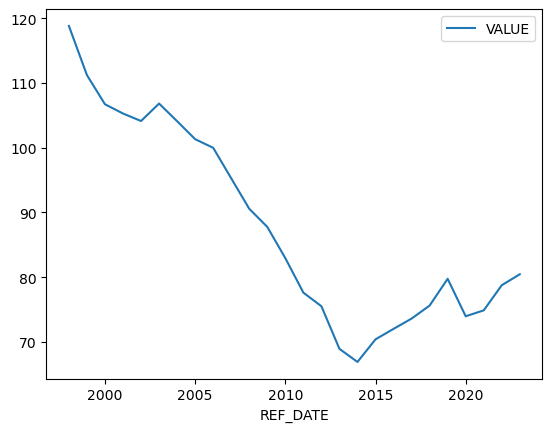

In [6]:
pdf = df[['REF_DATE', 'GEO', 'Statistics', 'VALUE']]

# Canada
pdf = pdf[(pdf['GEO'] == 'Canada') & (pdf['Statistics'] == 'Crime severity index')]

pdf = pdf.sort_values(by='REF_DATE')
pdf = pdf.set_index('REF_DATE')
pdf.plot()

In [7]:
def clean_statistics_column(x):
    """
    This function will clean the 'Statistics' column
    by replacing spaces with underscore
    and lower-casing values.
    """
    return (x.replace(' ', '_')
            .lower()
    )

# These are the values we will filter on under Statistics
values_of_interest = [
    'Crime severity index',
    'Weighted clearance rate',
]

# These are the only columns we will keep going forward
columns_of_interest = [
    'REF_DATE',
    'GEO',
    'Statistics',
    'VALUE'
]

In [8]:
params_prepare_crime_severity_data = {
    'dataframe': df,
    'values_of_interest': values_of_interest,
    'select_columns': columns_of_interest,
    'clean_function_dict': {
        'Statistics': clean_statistics_column,
    }
}

status_pcsd = cs.prepare_crime_severity_data(params_prepare_crime_severity_data)

Before data preparation...


,REF_DATE,GEO,Statistics,VALUE
0,1998,Canada,Crime severity index,118.84
1,1998,Canada,Violent crime severity index,97.80
2,1998,Canada,Non-violent crime severity index,126.93
3,1998,Canada,Youth crime severity index,110.24
4,1998,Canada,Youth violent crime severity index,86.59
5,1998,Canada,Youth non-violent crime severity index,128.25
6,1998,Canada,Weighted clearance rate,34.06
7,1998,Canada,Violent weighted clearance rate,55.66
8,1998,Canada,Non-violent weighted clearance rate,27.66
9,1998,Canada,Percent change in non-violent weighted clearan...,NaN


After data preparation...


/home/rohan/Documents/workspace/python/canada_crime/functions/crime_severity.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf[a_key] = pdf[a_key].apply(clean_function_dict.get(a_key))


Statistics,ref_date,geo,crime_severity_index,weighted_clearance_rate
0,1998,Alberta [48],122.50,40.89
1,1998,British Columbia [59],166.91,27.88
2,1998,"Calgary, Alberta [48825]",116.48,31.95
3,1998,Canada,118.84,34.06
4,1998,"Edmonton, Alberta [48835]",126.76,37.89
5,1998,"Greater Sudbury, Ontario [35580]",107.43,30.42
6,1998,"Halifax, Nova Scotia [12205]",134.13,28.95
7,1998,"Hamilton, Ontario [35537]",100.94,30.03
8,1998,"Kitchener-Cambridge-Waterloo, Ontario [35541]",100.61,30.84
9,1998,"London, Ontario [35555]",106.98,40.67


In [9]:
cs_df = status_pcsd.get('value', {})

display(cs_df.head(50))

Statistics,ref_date,geo,crime_severity_index,weighted_clearance_rate
0,1998,Alberta [48],122.50,40.89
1,1998,British Columbia [59],166.91,27.88
2,1998,"Calgary, Alberta [48825]",116.48,31.95
3,1998,Canada,118.84,34.06
4,1998,"Edmonton, Alberta [48835]",126.76,37.89
5,1998,"Greater Sudbury, Ontario [35580]",107.43,30.42
6,1998,"Halifax, Nova Scotia [12205]",134.13,28.95
7,1998,"Hamilton, Ontario [35537]",100.94,30.03
8,1998,"Kitchener-Cambridge-Waterloo, Ontario [35541]",100.61,30.84
9,1998,"London, Ontario [35555]",106.98,40.67


# Save the resulting dataset to a parquet file

In [10]:
import os
import os.path
import pandas as pd


filename = params_download_crime_severity_data.get('data_key', None)
filename += '.parquet'
output_path = os.path.join(project_parameters.data_folder, filename)

params_save_crime_severity_data_to_parquet = {
    'output_path': output_path,
    'input_dataframe': cs_df,
}


u.save_pandas_data_to_parquet(params_save_crime_severity_data_to_parquet)

{'status': 'True',
 'value': Statistics  ref_date                                  geo  \
 0               1998                         Alberta [48]   
 1               1998                British Columbia [59]   
 2               1998             Calgary, Alberta [48825]   
 3               1998                               Canada   
 4               1998            Edmonton, Alberta [48835]   
 ...              ...                                  ...   
 1222            2023  Vancouver, British Columbia [59933]   
 1223            2023   Victoria, British Columbia [59935]   
 1224            2023             Windsor, Ontario [35559]   
 1225            2023           Winnipeg, Manitoba [46602]   
 1226            2023                           Yukon [60]   
 
 Statistics  crime_severity_index  weighted_clearance_rate  
 0                         122.50                    40.89  
 1                         166.91                    27.88  
 2                         116.48          

In [11]:
check_df = pd.read_parquet(f'{output_path}')

check_df.head(5)

Statistics,ref_date,geo,crime_severity_index,weighted_clearance_rate
0,1998,Alberta [48],122.50,40.89
1,1998,British Columbia [59],166.91,27.88
2,1998,"Calgary, Alberta [48825]",116.48,31.95
3,1998,Canada,118.84,34.06
4,1998,"Edmonton, Alberta [48835]",126.76,37.89
